In [ ]:
!pip install tensorflow matplotlib seaborn

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2

tf.random.set_seed(42)

In [ ]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# expand dims and one-hot encode
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

In [ ]:
# subsample for training speed
x_train_sub, x_val_sub, y_train_cat_sub, y_val_cat_sub = train_test_split(x_train, y_train_cat, test_size=0.1, stratify=np.argmax(y_train_cat, axis=1))
x_test_sub, _, y_test_cat_sub, y_test_sub = train_test_split(x_test, y_test_cat, test_size=0.1, stratify=y_test)

# training and evaluation
x_train, y_train_cat = x_train_sub, y_train_cat_sub
x_test, y_test_cat, y_test = x_test_sub, y_test_cat_sub, y_test_sub

# Preprocess for Transfer Learning

In [ ]:
IMG_SIZE = 224

def preprocess(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))

    def _process_image(image, label):
        x_rgb = tf.image.grayscale_to_rgb(image)
        x_resized = tf.image.resize(x_rgb, [IMG_SIZE, IMG_SIZE])
        return x_resized, label

    dataset = dataset.map(_process_image)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_ds = preprocess(x_train, y_train_cat)
test_ds = preprocess(x_test, y_test_cat)

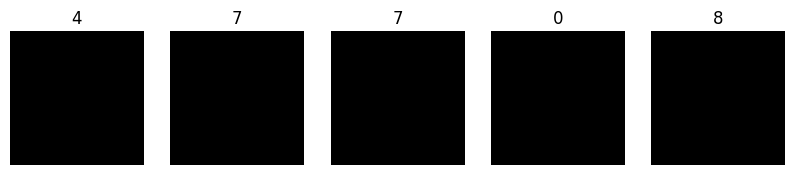

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(np.argmax(labels[i]))
        plt.axis("off")
    plt.show()

# Model Builder Function

In [ ]:
def build_transfer_model(base_fn, input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    base = base_fn(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg"
    )
    base.trainable = False

    # extract features from pretrained base
    x = base(inputs, training=False)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Train EfficientNetB0 and BiT (ResNet50V2)

In [ ]:
results = {}
models = {}

for name, backbone in {
    "EfficientNetB0": EfficientNetB0,
    "BiT_ResNet50V2": ResNet50V2
}.items():
    print(f"\nTraining {name}...")
    model = build_transfer_model(backbone)
    model.fit(train_ds, validation_data=test_ds, epochs=3, verbose=1)
    loss, acc = model.evaluate(test_ds)
    results[name] = acc
    models[name] = model


🔧 Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 107s 50ms/step - accuracy: 0.1081 - loss: 2.3090 - val_accuracy: 0.1134 - val_loss: 2.3011
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 65s 38ms/step - accuracy: 0.1132 - loss: 2.3015 - val_accuracy: 0.1134 - val_loss: 2.3011
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 65s 39ms/step - accuracy: 0.1132 - loss: 2.3015 - val_accuracy: 0.1134 - val_loss: 2.3011
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.1183 - loss: 2.3006

🔧 Training BiT_ResNet50V2...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 174s 95ms/step - accuracy: 0.8874 - loss: 0.3542 - val_accuracy: 0.9653 - val_loss: 0.1133
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 164s 77ms/step - accuracy: 0.9655 - loss: 0.1038 - val_accuracy: 0.9760 - val_loss: 0.0837
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 144s 78ms/step - accuracy: 0.9748 - loss: 0.0783 - val_accuracy

# MLP-Mixer from Scratch

In [ ]:
def build_mlp_mixer(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    # patch embedding
    x = layers.Conv2D(64, kernel_size=7, strides=4, padding="same")(x)
    x = layers.Reshape((-1, 64))(x)

    for _ in range(2):
        y = layers.LayerNormalization()(x)
        y = layers.Permute((2, 1))(y)
        y = layers.Dense(128, activation='gelu')(y)
        y = layers.Dense(x.shape[1])(y)
        y = layers.Permute((2, 1))(y)
        x = layers.Add()([x, y])
        y = layers.LayerNormalization()(x)
        y = layers.Dense(128, activation='gelu')(y)
        y = layers.Dense(64)(y)
        x = layers.Add()([x, y])

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
mlp_mixer = build_mlp_mixer()
mlp_mixer.fit(train_ds, validation_data=test_ds, epochs=3, verbose=1)
loss, acc = mlp_mixer.evaluate(test_ds)
results["MLP_Mixer"] = acc
models["MLP_Mixer"] = mlp_mixer

Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.7850 - loss: 0.6232 - val_accuracy: 0.9448 - val_loss: 0.1812
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.9501 - loss: 0.1649 - val_accuracy: 0.9511 - val_loss: 0.1641
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - accuracy: 0.9625 - loss: 0.1238 - val_accuracy: 0.9563 - val_loss: 0.1597
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9568 - loss: 0.1545


# ConvNeXtV2 Implementation

In [ ]:
def build_convnextv2(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 4, strides=4)(x)
    x = layers.LayerNormalization()(x)

    for filters in [128, 256]:
        shortcut = layers.Conv2D(filters, 2, strides=2)(x)
        x = layers.DepthwiseConv2D(7, padding='same')(shortcut)
        x = layers.LayerNormalization()(x)
        x = layers.Conv2D(filters*4, 1, activation='gelu')(x)
        x = layers.Conv2D(filters, 1)(x)
        x = layers.Add()([shortcut, x])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
convnext = build_convnextv2()
convnext.fit(train_ds, validation_data=test_ds, epochs=3, verbose=1)
loss, acc = convnext.evaluate(test_ds)
results["ConvNeXtV2"] = acc
models["ConvNeXtV2"] = convnext

Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.6965 - loss: 0.8527 - val_accuracy: 0.9753 - val_loss: 0.0829
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - accuracy: 0.9696 - loss: 0.0983 - val_accuracy: 0.9846 - val_loss: 0.0465
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - accuracy: 0.9781 - loss: 0.0706 - val_accuracy: 0.9852 - val_loss: 0.0422
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9863 - loss: 0.0424


# Compare All Results

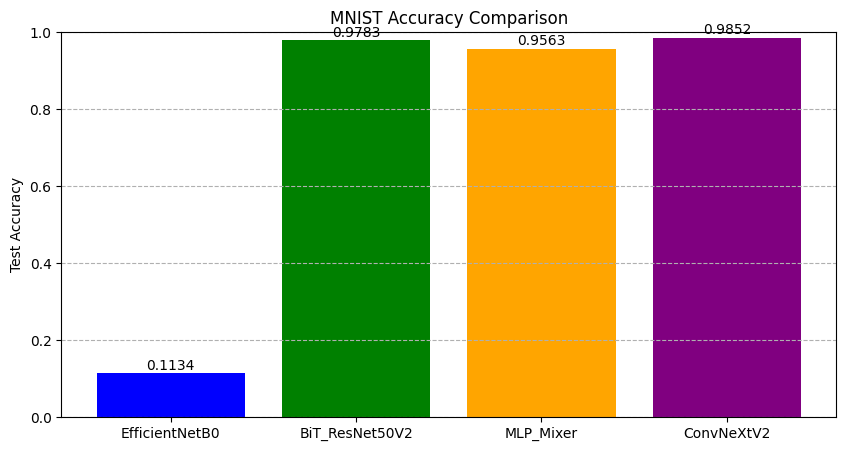

Best model: ConvNeXtV2 with accuracy: 0.9852


In [ ]:
plt.figure(figsize=(10, 5))
names = list(results.keys())
accs = list(results.values())
plt.bar(names, accs, color=["blue", "green", "orange", "purple"])
plt.title("MNIST Accuracy Comparison")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1.0)
for i, acc in enumerate(accs):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.grid(axis="y", linestyle="--")
plt.show()

best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")

In [ ]:
# save best model
models[best_model_name].save(f"best_mnist_model_{best_model_name}.h5")
print("Best model saved.")

Best model saved.
